In [1]:
import pandas as pd
import numpy as np
import time
from matplotlib import pyplot as plt
import datetime as dt
from zigzag_dag26 import zigzag
import talib
from tqdm import tqdm
import colorama as col
from retracement import ret_hilo
from bt import *
from fibostoch import Fibo_Stoch
from sklearn.preprocessing import MinMaxScaler

Importing Librairies...


In [2]:
%%time
##### Chargement de la base
base = pd.read_csv('Base_Clean/EURUSDm5.csv')

##### On fixe la date en index sous forme de Timestamp
base.set_index(pd.to_datetime(base.Date),drop=True,inplace=True)

###### On drop les colonnes inutiles
base = base.drop(['Date','Total'],axis=1)

##### On enlève les jours correspondant au samedi et au dimanche
base['WE'] = np.where(((base.index.weekday == 5) | (base.index.weekday == 6)),None,base.index.weekday)
base = base.dropna()
base = base.drop(['WE'],axis=1)


CPU times: user 2.05 s, sys: 270 ms, total: 2.32 s
Wall time: 2.34 s


In [3]:
base.index[0],base.index[-1]

(Timestamp('2010-11-23 00:00:00'), Timestamp('2020-11-23 15:40:00'))

In [34]:
%%time
_year_bottom = pd.to_datetime('2020-01-01 16:00:00')
_year_top = pd.to_datetime('2020-12-31 16:00:00') #2020-11-23 16:00:00

df = base[(base.index>=_year_bottom)&(base.index<=_year_top)]

df_input = df.copy()

df_bt = df.copy()

CPU times: user 19.2 ms, sys: 11.1 ms, total: 30.3 ms
Wall time: 26.1 ms


In [35]:
df['HiWin'] = df.High.rolling(10).max()
df['LoWin'] = df.Low.rolling(10).min()
df['JyssOscUp'] = ((df.HiWin-df.HiWin.shift(2))/df.HiWin.shift(2))*1000
df['JyssOscUpSD'] = df.JyssOscUp.rolling(20).std()
df['JyssOscDwn'] = ((df.LoWin-df.LoWin.shift(2))/df.LoWin.shift(2))*1000
df['JyssOscDwnSD'] = df.JyssOscDwn.rolling(20).std()
df['TriggerBull'] = (df.HiWin - df.HiWin.shift(2)) * 1000
df['TriggerBear'] = (df.LoWin - df.LoWin.shift(2)) * 1000
df['Trigger'] = np.where((df.LoWin - df.LoWin.shift(9) == 0),1,np.where((df.HiWin - df.HiWin.shift(9) == 0 ),1,0))

#df['SBVol'] = upper - lower

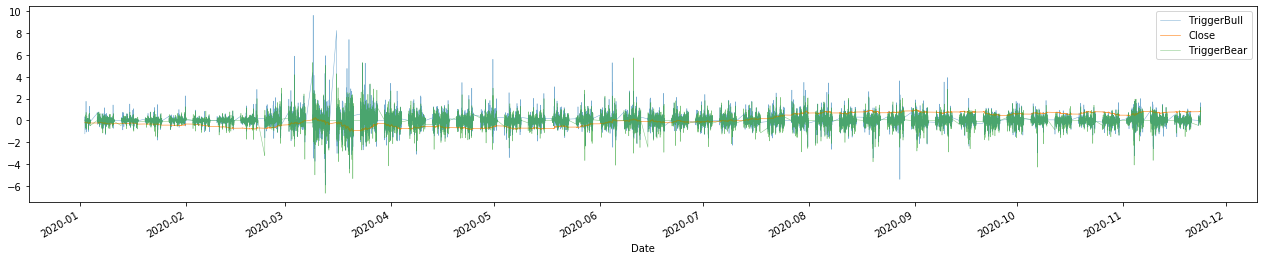

In [36]:
scaler = MinMaxScaler((-1,1))
df.TriggerBull.plot(figsize=(22,4),linewidth=0.5,alpha=0.6)
plt.plot(df.Close.index,scaler.fit_transform(df.Close.values.reshape(-1,1)),label='Close',alpha=0.8,linewidth=0.7)
df.TriggerBear.plot(figsize=(22,4),linewidth=0.5,alpha=0.6)

plt.legend()

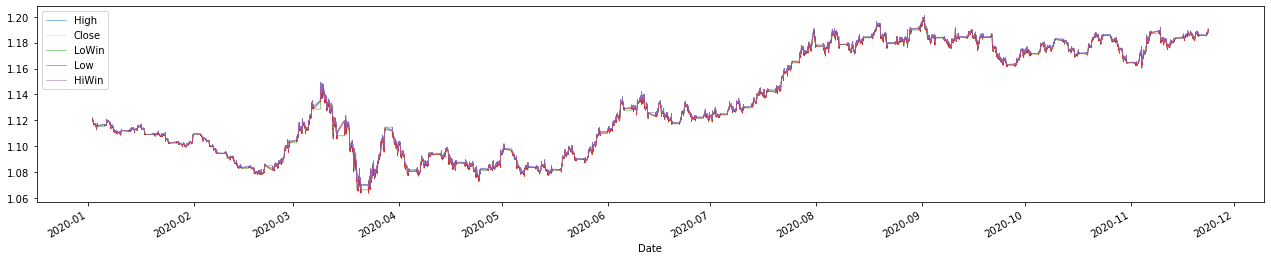

In [37]:
df.High.plot(figsize=(22,4),linewidth=0.5)
df.Close.plot(figsize=(22,4),alpha=0.5,linewidth=0.5)
df.LoWin.plot(figsize=(22,4),linewidth=0.5)
df.Low.plot(figsize=(22,4),linewidth=0.5)
df.HiWin.plot(figsize=(22,4),linewidth=0.5)

plt.legend()

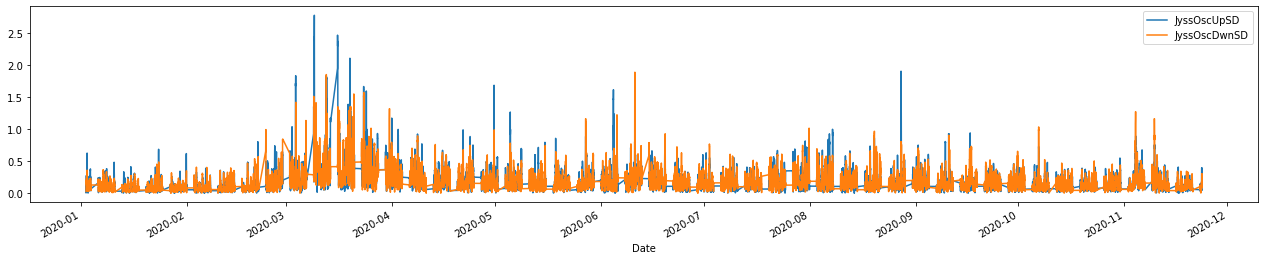

In [38]:
df.JyssOscUpSD.plot(figsize=(22,4))
df.JyssOscDwnSD.plot(figsize=(22,4))
plt.legend()

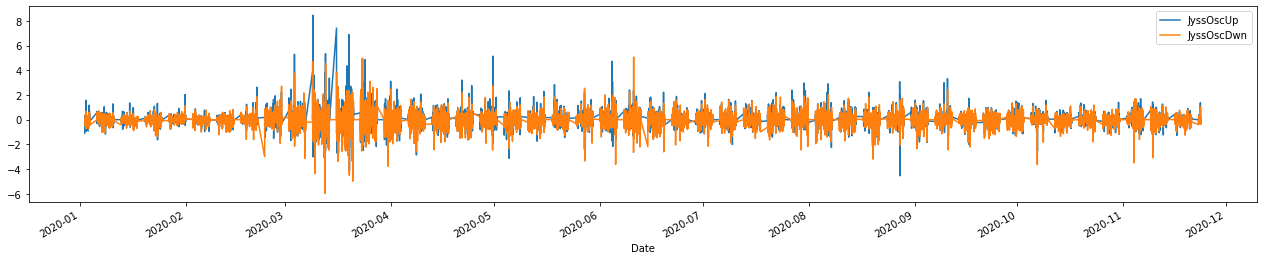

In [39]:
df.JyssOscUp.plot(figsize=(22,4))
df.JyssOscDwn.plot(figsize=(22,4))
plt.legend()

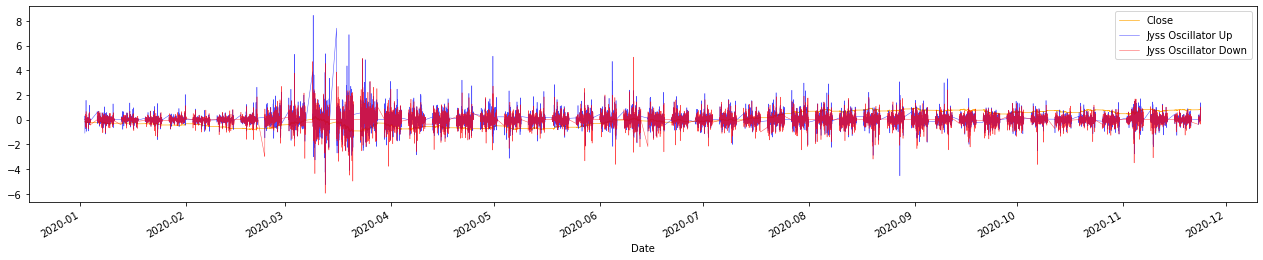

In [40]:

scaler = MinMaxScaler((-1,1))
plt.plot(df.Close.index,scaler.fit_transform(df.Close.values.reshape(-1,1)),label='Close',alpha=0.9,linewidth=0.7,color='orange')
df.JyssOscUp.plot(figsize=(22,4),label='Jyss Oscillator Up',alpha=0.7,linewidth=0.5,color='b')
df.JyssOscDwn.plot(figsize=(22,4),label='Jyss Oscillator Down',alpha=0.7,linewidth=0.5,color='r')
#df.JyssOscUpSD.plot(label='Std du Jyss Oscillator Up',alpha=0.7,linewidth=0.5)
#df.JyssOscDwnSD.plot(label='Std du Jyss Oscillator Down',alpha=0.7,linewidth=0.5)
#plt.plot(df.TriggerBull.index,scaler.fit_transform(df.TriggerBull.values.reshape(-1,1)),label='Trigger Bull',alpha=0.7,linewidth=0.5)
#plt.plot(df.TriggerBear.index,scaler.fit_transform(df.TriggerBear.values.reshape(-1,1)),label='Trigger Bear',alpha=0.7,linewidth=0.5)
plt.legend()
#plt.savefig('JyssOscillator',dpi=1000)


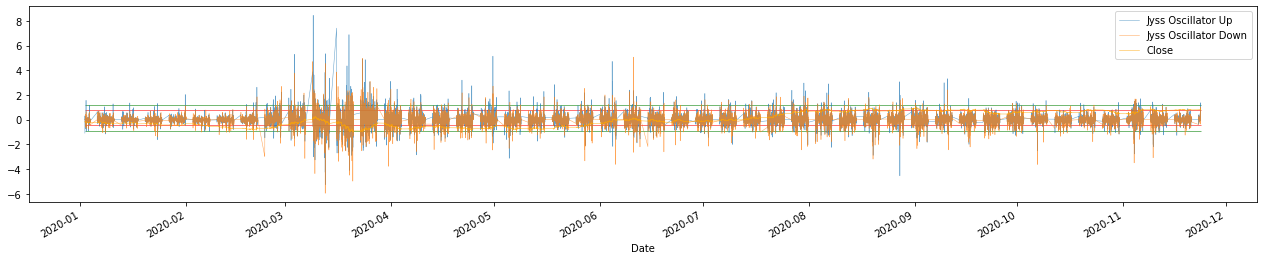

In [41]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler((-1,1))
df.JyssOscUp.plot(figsize=(22,4),label='Jyss Oscillator Up',alpha=0.7,linewidth=0.5)
df.JyssOscDwn.plot(figsize=(22,4),label='Jyss Oscillator Down',alpha=0.7,linewidth=0.5)
plt.plot(df.Close.index,scaler.fit_transform(df.Close.values.reshape(-1,1)),label='Close',color='orange',alpha=0.7,linewidth=0.6)
plt.hlines(xmin=df.index[0],xmax=df.index[-1],y=4*df.JyssOscUp.std(),color='green',alpha=0.9,linewidth=0.6)
plt.hlines(xmin=df.index[0],xmax=df.index[-1],y=-3*df.JyssOscUp.std(),color='green',alpha=0.9,linewidth=0.6)
plt.hlines(xmin=df.index[0],xmax=df.index[-1],y=2.5*df.JyssOscUp.std(),color='red',alpha=0.9,linewidth=0.6)
plt.hlines(xmin=df.index[0],xmax=df.index[-1],y=-1.5*df.JyssOscUp.std(),color='red',alpha=0.9,linewidth=0.6)
plt.legend()

In [42]:
'''df['Signal'] = np.where(\
    ((df.Close <= 1.01*df.LoWin)&(df.JyssOsc <= -4*df.JyssOscSD)),1,\
        np.where(\
            ((df.Close >= 0.99*df.HiWin)&(df.JyssOsc >= 4*df.JyssOscSD)),-1,0)
)
df['SignalClose'] = np.where(\
    ((df.Close >= 0.99*df.HiWin)&(df.JyssOsc <= -3*df.JyssOscSD)),1,\
        np.where(\
            ((df.Close <= 1.01*df.LoWin)&(df.JyssOsc >= 3*df.JyssOscSD)),-1,0)
)'''

"df['Signal'] = np.where(    ((df.Close <= 1.01*df.LoWin)&(df.JyssOsc <= -4*df.JyssOscSD)),1,        np.where(            ((df.Close >= 0.99*df.HiWin)&(df.JyssOsc >= 4*df.JyssOscSD)),-1,0)\n)\ndf['SignalClose'] = np.where(    ((df.Close >= 0.99*df.HiWin)&(df.JyssOsc <= -3*df.JyssOscSD)),1,        np.where(            ((df.Close <= 1.01*df.LoWin)&(df.JyssOsc >= 3*df.JyssOscSD)),-1,0)\n)"

In [43]:
df['Signal'] = np.where(\
    ((df.Close <= 1.01*df.LoWin)&(df.JyssOscUp <= -4*df.JyssOscUpSD)),1,\
        np.where(\
            ((df.Close >= 0.99*df.HiWin)&(df.JyssOscDwn >= 4*df.JyssOscDwnSD)),-1,0)
)
df['SignalClose'] = np.where(\
    ((df.Close >= 0.99*df.HiWin)&(df.JyssOscDwn <= -3*df.JyssOscDwnSD)),1,\
        np.where(\
            ((df.Close <= 1.01*df.LoWin)&(df.JyssOscUp >= 3*df.JyssOscUpSD)),-1,0)
)

In [44]:

'''df['Signal'] = np.where(\
    ((df.Close <= 1.01*df.LoWin)&(abs(df.JyssOsc)/df.JyssOscSD >= 0.5 )),1,\
        np.where(\
            ((df.Close >= 0.99*df.HiWin)&(abs(df.JyssOsc)/df.JyssOscSD >= 0.5 )),-1,0)
)
df['SignalClose'] = np.where(\
    ((df.Close >= 0.99*df.HiWin)&(df.JyssOsc <= -3*df.JyssOscSD)),1,\
        np.where(\
            ((df.Close <= 1.01*df.LoWin)&(df.JyssOsc >= 3*df.JyssOscSD)),-1,0)
)'''

'''df['Signal'] = np.where(\
    ((df.JyssOsc/df.JyssOscSD >= 1)&(df.Trigger == 1)),1,\
        np.where(\
            ((df.JyssOsc/df.JyssOscSD <= -0.2 )&(df.Trigger == 1)),-1,0)
)
df['SignalClose'] = np.where(\
    ((df.JyssOsc <= -3*df.JyssOscSD)),1,\
        np.where(\
            ((df.JyssOsc >= 3*df.JyssOscSD)),-1,0)
)'''

"df['Signal'] = np.where(    ((df.JyssOsc/df.JyssOscSD >= 1)&(df.Trigger == 1)),1,        np.where(            ((df.JyssOsc/df.JyssOscSD <= -0.2 )&(df.Trigger == 1)),-1,0)\n)\ndf['SignalClose'] = np.where(    ((df.JyssOsc <= -3*df.JyssOscSD)),1,        np.where(            ((df.JyssOsc >= 3*df.JyssOscSD)),-1,0)\n)"

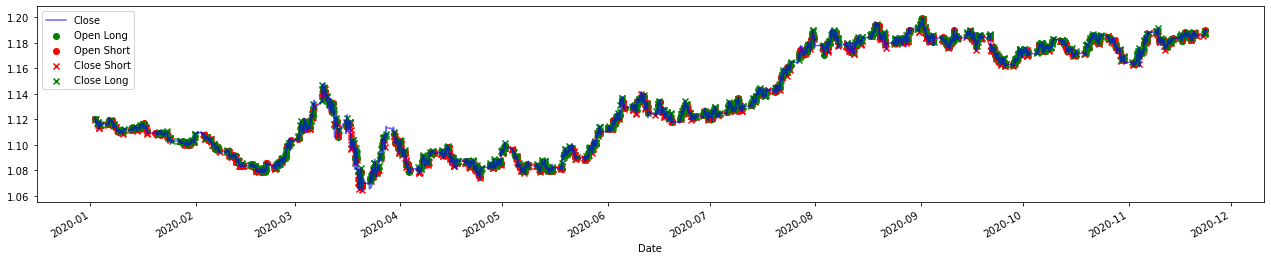

In [45]:
df.Close.plot(figsize=(22,4),label='Close',color='b',alpha=0.6)

plt.scatter(x=df[df.Signal==1].index,y=df[df.Signal==1].Close,color='green',marker='o',label='Open Long')

plt.scatter(x=df[df.Signal==-1].index,y=df[df.Signal==-1].Close,color='red',marker='o',label='Open Short')

plt.scatter(x=df[df.SignalClose==1].index,y=df[df.SignalClose==1].Close,color='red',marker='x',label='Close Short')

plt.scatter(x=df[df.SignalClose==-1].index,y=df[df.SignalClose==-1].Close,color='green',marker='x',label='Close Long')

plt.legend()

In [46]:
_nb_bougie_exit = 96000000
_trigger_reengage = 0
_trigger_target = 0
_trigger_invers = 1
_trigger_sl = 0
_verbose = 0
_cash_ini = 200000
_rate = 1
x = 'EUR/USD'
_target = 0.001
_exposure = 3
_size = 50000
_sl = 0.006
TRACKER = bt(df,_year_bottom,_year_top,_nb_bougie_exit,_trigger_reengage,_trigger_target,_trigger_invers,_trigger_sl,_verbose,_cash_ini,\
        _rate,x,_target,_exposure,_size,_sl)

Librairies imported

Début des opérations horodatée à 2020-12-11 14:15:34.036790

Chargement de la nouvelle base


 Le rate du ticker EUR/USD est à  1 
Bases chargées
TETEL process effectué
 ENTERING THE BACKTEST 
100%|██████████| 66027/66027 [00:08<00:00, 8008.70it/s]
 Pour le ticker  EUR/USD 
 
Les gains faramineux s'élèvent à : $  -392.5 !. En  150   transactions.
 
Nbre de winners : 84 
 
Nbre de loosers : 66 
Temps d'excution du BT 0:00:14.514308
 EUR/USD  results 
 Tested Period 2020-01-01 16:00:00  à 2020-12-31 16:00:00 
 Total Number of trades 150 
Started Cash : 50000
P&L in currency:  -392.5$ 
P&L in %:  -0.2% 
Average trade duration 284.67
# Winners  84.0
# Loosers  66.0
Cumulated gains 14046.0
Cumulated losses -14438.5
 PROFIT FACTOR :  0.97 
 Winners Ratio : 56.0 % 
Average Winners 93.64
Average Loosers -96.26
Average pnl -2.62
% Average Winners 0.05
% Average Loosers -0.05
% Average pnl -0.0
Number of opened trades 150
Number of closed trades 150
Max Exposure 1 x  50000 =

In [17]:
len(TRACKER)

95

In [18]:
%%time
_model = 'svm'
scaler = MinMaxScaler((0,1))
df_2 = df.copy()
df_2 = df_2.drop(['SignalClose'],axis=1)
df_2.loc[:, df_2.columns != 'Signal'] = scaler.fit_transform(df_2.loc[:, df_2.columns != 'Signal'].values) 
df_2.rename(columns = {'Signal':'Sig4bt'}, inplace = True)
SIGNAL = []
SIGNAL = [1 if (df_2.Sig4bt[i] != 0) & (df_2.index[i] in TRACKER) else 0 for i in tqdm(range(len(df_2)))]
df_2['Signal'] = SIGNAL
df_2 = df_2[['HigMax','LowMin','HiWin','LoWin','JyssOscUp','JyssOscUpSD','JyssOscDwn','JyssOscDwnSD',\
                                    'TriggerBull','TriggerBear','Trigger','Sig4bt','Signal']]
df_2 = df_2.dropna()


100%|██████████| 73147/73147 [00:04<00:00, 16652.34it/s]
CPU times: user 4.64 s, sys: 85.4 ms, total: 4.73 s
Wall time: 4.73 s


In [19]:
from svm import modelize
modelize(df_2[df_2.Sig4bt != 0],x,_model,0)

 Support Vector Machine pour  EUR/USD 
Signaux achat Counter({0: 410, 1: 95})
 Achat pour  EUR/USD 

Achat - Accuracy : 73.73 %
Achat - Precision : 20.45 %
Achat - Recall : 13.43 %
Achat - F-measure: : 16.22 % 


 Achat pour  EUR/USD 

Achat - Accuracy : 23.45 %
Achat - Precision : 19.28 %
Achat - Recall : 95.52 %
Achat - F-measure: : 32.08 % 


 Achat pour  EUR/USD 

Achat - Accuracy : 19.21 %
Achat - Precision : 18.98 %
Achat - Recall : 100.0 %
Achat - F-measure: : 31.9 % 


 Achat pour  EUR/USD 

Achat - Accuracy : 63.56 %
Achat - Precision : 14.77 %
Achat - Recall : 19.4 %
Achat - F-measure: : 16.77 % 


 Achat pour  EUR/USD 

Achat - Accuracy : 23.16 %
Achat - Precision : 18.65 %
Achat - Recall : 91.04 %
Achat - F-measure: : 30.96 % 


 Achat pour  EUR/USD 

Achat - Accuracy : 60.45 %
Achat - Precision : 18.26 %
Achat - Recall : 31.34 %
Achat - F-measure: : 23.08 % 


 Achat pour  EUR/USD 

Achat - Accuracy : 20.9 %
Achat - Precision : 17.43 %
Achat - Recall : 85.07 %
Achat - F-me

()

In [41]:
from bag import modelize
_model = 'bag'
modelize(df_2[df_2.Sig4bt != 0],x,_model,0)

 Bagging K Neigbhors Classifier pour  EUR/USD 
Signaux achat Counter({0: 410, 1: 95})
 Achat pour  EUR/USD 

Achat - Accuracy : 81.07 %
Achat - Precision : 0.0 %
Achat - Recall : 0.0 %
Achat - F-measure: : 0.0 % 


 Achat pour  EUR/USD 

Achat - Accuracy : 81.07 %
Achat - Precision : 0.0 %
Achat - Recall : 0.0 %
Achat - F-measure: : 0.0 % 


 Achat pour  EUR/USD 

Achat - Accuracy : 81.07 %
Achat - Precision : 0.0 %
Achat - Recall : 0.0 %
Achat - F-measure: : 0.0 % 


 Achat pour  EUR/USD 

Achat - Accuracy : 81.07 %
Achat - Precision : 0.0 %
Achat - Recall : 0.0 %
Achat - F-measure: : 0.0 % 


 Achat pour  EUR/USD 

Achat - Accuracy : 81.07 %
Achat - Precision : 0.0 %
Achat - Recall : 0.0 %
Achat - F-measure: : 0.0 % 


 Achat pour  EUR/USD 

Achat - Accuracy : 81.07 %
Achat - Precision : 0.0 %
Achat - Recall : 0.0 %
Achat - F-measure: : 0.0 % 


 Achat pour  EUR/USD 

Achat - Accuracy : 81.07 %
Achat - Precision : 0.0 %
Achat - Recall : 0.0 %
Achat - F-measure: : 0.0 % 


 Achat pour

()

In [30]:
%%time
_model = 'svm'
_year_bottom = pd.to_datetime('2020-01-01 16:00:00')
_year_top = pd.to_datetime('2020-11-23 16:00:00') #2020-11-23 16:00:00

df_oos = base[(base.index>=_year_bottom)&(base.index<=_year_top)]

df_oos['HiWin'] = df_oos.High.rolling(10).max()
df_oos['LoWin'] = df_oos.Low.rolling(10).min()
df_oos['JyssOscUp'] = ((df_oos.HiWin - df_oos.HiWin.shift(2)) / df_oos.HiWin.shift(2))*1000
df_oos['JyssOscUpSD'] = df_oos.JyssOscUp.rolling(20).std()
df_oos['JyssOscDwn'] = ((df_oos.LoWin - df_oos.LoWin.shift(2)) / df_oos.LoWin.shift(2))*1000
df_oos['JyssOscDwnSD'] = df_oos.JyssOscDwn.rolling(20).std()
df_oos['TriggerBull'] = (df_oos.HiWin - df_oos.HiWin.shift(2)) * 1000
df_oos['TriggerBear'] = (df_oos.LoWin - df_oos.LoWin.shift(2)) * 1000
df_oos['Trigger'] = np.where((df_oos.LoWin - df_oos.LoWin.shift(9) == 0),1,np.where((df_oos.HiWin - df_oos.HiWin.shift(9) == 0 ),1,0))


df_oos['Signal'] = np.where(\
    ((df_oos.Close <= 1.01 * df_oos.LoWin) & (df_oos.JyssOscUp <= -4*df_oos.JyssOscUpSD)),1,\
        np.where(\
            ((df_oos.Close >= 0.99 * df_oos.HiWin) & (df_oos.JyssOscDwn >= 4*df_oos.JyssOscDwnSD)),-1,0)
)
df_oos['SignalClose'] = np.where(\
    ((df_oos.Close >= 0.99 * df_oos.HiWin) & (df_oos.JyssOscDwn <= -3 * df_oos.JyssOscDwnSD)),1,\
        np.where(\
            ((df_oos.Close <= 1.01 * df_oos.LoWin) & (df_oos.JyssOscUp >= 3 * df_oos.JyssOscUpSD)),-1,0)
)


df_oos = df_oos.drop(['SignalClose'],axis=1)
df_oos.loc[:, df_oos.columns != 'Signal'] = scaler.fit_transform(df_oos.loc[:, df_oos.columns != 'Signal'].values) 
df_oos.rename(columns = {'Signal':'Sig4bt'}, inplace = True)

#df_oos = df_oos[['HigMax','LowMin','HiWin','LoWin','JyssOscUp','JyssOscUpSD','JyssOscDwn','JyssOscDwnSD',\
#                                    'TriggerBull','TriggerBear','Trigger','Sig4bt']]
loaded_model = joblib.load('JOBLIB/'+_model+'/SaveEURUSDm5.sav')
df_oos = df_oos.dropna()
df_oos['Signal_hat'] = loaded_model.predict(df_oos[['HigMax','LowMin','HiWin','LoWin','JyssOscUp','JyssOscUpSD','JyssOscDwn','JyssOscDwnSD',\
                                    'TriggerBull','TriggerBear','Trigger','Sig4bt']])



CPU times: user 315 ms, sys: 50.4 ms, total: 365 ms
Wall time: 365 ms


In [32]:
%%time
df_oos['Signal'] = np.where(
                            ((df_oos.Sig4bt == 1)&(df_oos.Signal_hat==0)),1,\
                                np.where(((df_oos.Sig4bt == -1)&(df_oos.Signal_hat==0)),-1,0)


)
#result = loaded_model.score(X_test, Y_test)

CPU times: user 3.11 ms, sys: 1.18 ms, total: 4.29 ms
Wall time: 3.2 ms


In [33]:
TRACKER = bt(df_oos,_year_bottom,_year_top,_nb_bougie_exit,_trigger_reengage,_trigger_target,_trigger_invers,_trigger_sl,_verbose,_cash_ini,\
        _rate,x,_target,_exposure,_size,_sl)

Librairies imported

Début des opérations horodatée à 2020-12-11 14:12:24.300553

Chargement de la nouvelle base


 Le rate du ticker EUR/USD est à  1 
Bases chargées
TETEL process effectué
 ENTERING THE BACKTEST 
100%|██████████| 66027/66027 [00:08<00:00, 7841.74it/s]
 Pour le ticker  EUR/USD 
 
Les gains faramineux s'élèvent à : $  12784.61 !. En  37   transactions.
 
Nbre de winners : 27 
 
Nbre de loosers : 10 
Temps d'excution du BT 0:00:14.700963
 EUR/USD  results 
 Tested Period 2020-01-01 16:00:00  à 2020-11-23 16:00:00 
 Total Number of trades 37 
Started Cash : 50000
P&L  in currency:  12784.61$ 
P&L in %:  6.39% 
Average trade duration 1259.49
# Winners  27.0
# Loosers  10.0
Cumulated gains 33401.53
Cumulated losses -20616.92
 PROFIT FACTOR :  1.62 
 Winners Ratio : 72.97 % 
Average Winners 902.74
Average Loosers -557.21
Average pnl 345.53
% Average Winners 0.45
% Average Loosers -0.28
% Average pnl 0.17
Number of opened trades 37
Number of closed trades 37
Max Exposure 1 x 

In [29]:
len(df_oos[df_oos.Signal==0])

136